In [1]:
import torch
import matplotlib.pyplot as plt
import scipy

Fetch data used in this doc: https://uk.mathworks.com/help/deeplearning/ug/solve-pde-using-fourier-neural-operator.html

Data is:
 - 1-d burgers with periodic boundary condition
 - `u` = PDE solution at 1 timestep. `a` = initial contidion

In [3]:
!curl https://ssd.mathworks.com/supportfiles/nnet/data/burgers1d/burgers_data_R10.mat -o burgers_data_R10.mat

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  614M  100  614M    0     0  8482k      0  0:01:14  0:01:14 --:--:-- 8850k


In [4]:
data = scipy.io.loadmat("burgers_data_R10.mat")
a, u = data["a"], data["u"]

In [5]:
print(a.shape, u.shape)

(2048, 8192) (2048, 8192)


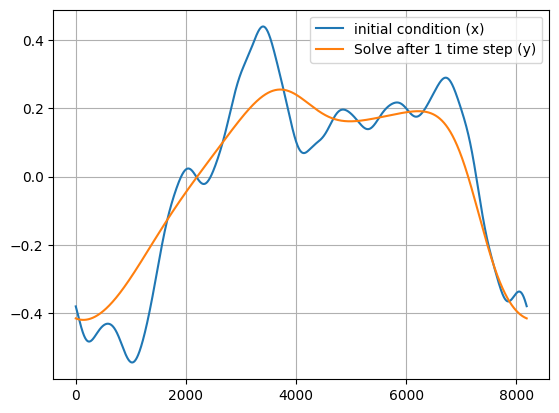

In [9]:
plt.plot(a[2], label="initial condition (x)")
plt.plot(u[2], label="Solve after 1 time step (y)")
plt.legend()
plt.grid()

In [10]:
a, u = torch.tensor(a), torch.tensor(u)

In [12]:
# Add a channel dimension
a = a.unsqueeze(-2)
u = u.unsqueeze(-2)
print(a.shape, u.shape)

torch.Size([2048, 1, 8192]) torch.Size([2048, 1, 8192])


In [14]:
# Domain is defined from 0 -> 2*pi
mesh = torch.linspace(0, 2*torch.pi, a.shape[-1])

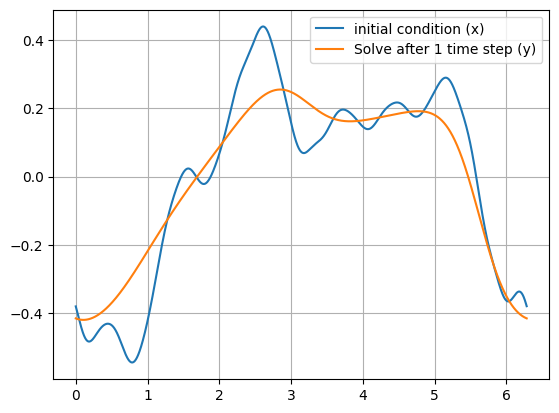

In [15]:
plt.plot(mesh, a[2, 0], label="initial condition (x)")
plt.plot(mesh, u[2, 0], label="Solve after 1 time step (y)")
plt.legend()
plt.grid()

In [26]:
mesh = mesh.reshape(1,1, a.shape[-1]).repeat(a.shape[0], 1, 1)

In [28]:
# Concat mesh as additional channel
a_with_mesh = torch.concat((a, mesh), dim=-2)
a_with_mesh.shape

torch.Size([2048, 2, 8192])

In [29]:
train_x, test_x = a_with_mesh[:1000], a_with_mesh[1000:1200]
train_y, test_y = u[:1000], u[1000:1200]

In [124]:
import torch.nn.functional as F
from torch import nn

class SpectralConv1d(nn.Module):
    def __init__(self, in_channels, out_channels, modes):
        super().__init__()

        self.in_channels = in_channels
        self.out_channels = out_channels
        self.modes = modes

        self.scale = 1 / (in_channels * out_channels)

        self.w_real = nn.Parameter(torch.empty((in_channels, out_channels, self.modes)))
        self.w_imag = nn.Parameter(torch.empty((in_channels, out_channels, self.modes)))

        nn.init.uniform_(self.w_real, a=-self.scale, b=self.scale)
        nn.init.uniform_(self.w_imag, a=-self.scale, b=self.scale)
        

    # Complex multiplication
    def compl_mul1d(self, input, weights):
        # (batch, in_channel, x ), (in_channel, out_channel, x) -> (batch, out_channel, x)
        return torch.einsum("bix,iox->box", input, weights)

    def forward(self, x):
        batchsize = x.shape[0]
        
        # (batch, input_channels, spatial_points//2+1)
        x_fft = torch.fft.rfft(x)
        x_fft_under_modes = x_fft[:, :, : self.modes]

        # (batch, output_channels, spatial_points//2+1)
        out_fft = torch.zeros(
            batchsize,
            self.out_channels,
            x_fft.shape[-1], 
            device=x.device,
            dtype=torch.cfloat,
        )

        weights = self.w_real + 1j * self.w_imag
        
        out_fft[:, :, : self.modes] = self.compl_mul1d(
            x_fft_under_modes, weights
        )

        # Return to physical space
        return torch.fft.irfft(out_fft, n=x.size(-1))

In [125]:
class FNOBlock1d(nn.Module):
    def __init__(self, in_channels, out_channels, modes, activation):
        super().__init__()

        self.spectral_conv = SpectralConv1d(in_channels, out_channels, modes)
        self.skip_connection_conv = nn.Conv1d(in_channels, out_channels, 1)
        self.activation = activation

    def forward(self, x):
        return self.activation(self.spectral_conv(x) + self.skip_connection_conv(x))


In [136]:
class FNO1d(nn.Module):
    def __init__(self, input_channels, output_channels, modes, hidden_width, activation, n_fno_blocks=4):
        super().__init__()

        self.lifting = nn.Conv1d(input_channels, hidden_width, 1)

        self.fno_blocks = nn.ModuleList()
        for _ in range(n_fno_blocks):
            self.fno_blocks.append(
                FNOBlock1d(hidden_width, hidden_width, modes, activation)
            )

        self.projection = nn.Conv1d(hidden_width, output_channels, 1)

    def forward(self, x):
        x = self.lifting(x)
        for fno_block in self.fno_blocks:
            x = fno_block(x)

        x = self.projection(x)
        return x

In [138]:
from torch.utils.data import DataLoader, TensorDataset
from tqdm.auto import tqdm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
dtype = torch.float32

model = FNO1d(
    input_channels=2,
    output_channels=1,
    hidden_width=64,
    modes=16,
    n_fno_blocks=4,
    activation=nn.ReLU()
).to(device)

train_loader = DataLoader(TensorDataset(train_x.to(dtype), train_y.to(dtype)), batch_size=100, shuffle=True)

optimizer = torch.optim.Adam(model.parameters(), lr=3e-4)
loss_fn = nn.MSELoss()

epochs = 50
pbar = tqdm(range(epochs), desc="Training")

train_resolution = 256
train_substep = int(train_x.shape[-1] / train_resolution)

loss_hist = []

for epoch in pbar:
    model.train()
    total_loss = 0
    
    for x_batch, y_batch in train_loader:
        x_batch, y_batch = x_batch[..., ::train_substep].to(device), y_batch[..., ::train_substep].to(device)
        
        optimizer.zero_grad()
        outputs = model(x_batch)
        loss = loss_fn(outputs, y_batch)
        
        loss.backward()
        optimizer.step()
        
        loss_hist.append(loss.item())

Training: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [01:22<00:00,  1.65s/it]


### Plot some stuff

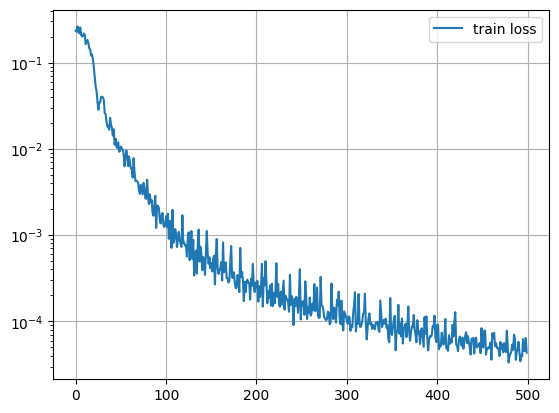

In [139]:
plt.plot(loss_hist, label="train loss")
plt.legend()
plt.yscale("log")
plt.grid()

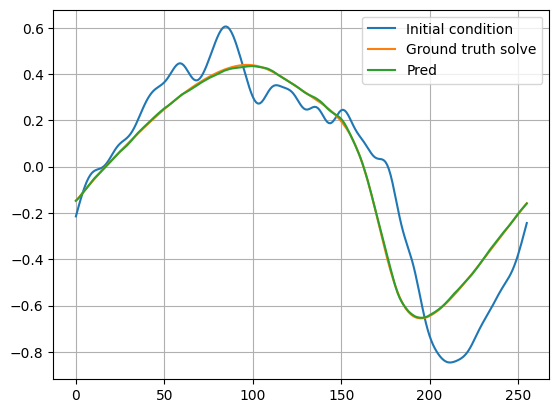

In [140]:
model.eval()

plt.plot(test_x[1, 0, ::32], label="Initial condition")
plt.plot(test_y[1, 0, ::32], label="Ground truth solve")
plt.plot(model(test_x[1:2, :, ::32].to(dtype)).detach()[0, 0], label="Pred")
plt.legend()
plt.grid()